<center><h1>Zhao_Yichen_FP</h1></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Name: Yichen Zhao

Github username: Iannnzyc

USC ID: 4488183532

In [ ]:
import glob
import os
import random
import math
import shutil
import cv2
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploration and Pre-processing

### Split training, validation, test

In [ ]:
os.makedirs('/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/train')
os.makedirs('/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/val')
os.makedirs('/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/test')
for directory in glob.glob('/content/drive/MyDrive/DSCI552/Data/Sport Images/*'):
    folder_name = os.path.basename(directory)
    if folder_name in ['Image URLs', 'Processed']:
        continue
#     print(directory)
    
    all_files = [f for f in os.listdir(directory)]
    random.shuffle(all_files)
    
    n = len(os.listdir(directory))
    n_train = math.ceil(0.7*n)
    n_val = math.ceil(0.15*n)
    n_test = n - n_train - n_val
    
    train_files = all_files[:n_train]
    val_files = all_files[n_train:n_train + n_val]
    test_files = all_files[n_train + n_val:]
    
    os.makedirs(f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/train/{folder_name}')
    os.makedirs(f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/val/{folder_name}')
    os.makedirs(f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/test/{folder_name}')
    
    for f in train_files:
        shutil.copy(f'{directory}/{f}', f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/train/{folder_name}/{f}')
    for f in val_files:
        shutil.copy(f'{directory}/{f}', f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/val/{folder_name}/{f}')
    for f in test_files:
        shutil.copy(f'{directory}/{f}', f'/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/test/{folder_name}/{f}')
    
#         splitfolders.fixed(directory, output='../Data/image_set', fixed=(n_train, n_val, n_test))

### Resize the images

In [ ]:
base_folder = '/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed'
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if os.path.isdir(folder_path):
        for activity_folder in os.listdir(folder_path):
            activity_path = os.path.join(folder_path, activity_folder)
            for file in os.listdir(activity_path):
                file_path = os.path.join(activity_path, file)
#                 if file_path.endswith('.gif'):
                img = Image.open(file_path)
                img_resized = img.resize((224,224), Image.ANTIALIAS)
                img_resized.save(file_path, format=img.format)
#                 else:
#                     img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
#                     img_resized = cv2.resize(img, (224,224))
#                     cv2.imwrite(file_path, img_resized)

# Transfer Learning for Image Classification

In [ ]:
def augment_image(image):
    # Randomly flip the image
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    # Randomly rotate the image
    angle = random.uniform(-20,20)
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (width,height))
    
    # Randomly translate the image
    tx = random.uniform(-0.1*width, 0.1*width)
    ty = random.uniform(-0.1*height, 0.1*height)
    translation_matrix = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, translation_matrix, (width, height))
    
    # Randomly adjust the brightness and contrast of the image
    brightness = random.uniform(0.5, 1.5)
    contrast = random.uniform(0.7, 1.3)
    image = cv2.convertScaleAbs(image, alpha = contrast, beta=brightness*100-100)
    
    # Randomly zoom the image
    zoom_factor = random.uniform(0.9, 1.1)
    image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    
    image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    
    return image

In [ ]:
train_folder = '/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/train'
for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.gif'):
            continue
        file_path = os.path.join(folder_path, file)
        image = cv2.imread(file_path)
        image_augmented = augment_image(image)
        augmented_file_path = os.path.join(folder_path, f'augmented_{file}')
        cv2.imwrite(augmented_file_path, image_augmented)

In [ ]:
def create_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(552))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    
    optimizer = tf.keras.optimizers.legacy.Adam()
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
def train_model(model, model_name, train, val, batch_size=5, epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train, epochs=epochs, batch_size=batch_size, validation_data=val, callbacks=[early_stopping])
    
    return history
def plot_loss(history, model_name):
    plt.figure()
    plt.plot([1 - a for a in history.history['accuracy']], label='Training Error')
    plt.plot([1 - a for a in history.history['val_accuracy']], label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.title(f'{model_name} Training and Validation Error')
    plt.legend()
    plt.show()

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
train_path = '/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/train'
val_path = '/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/val'
test_path = '/content/drive/MyDrive/DSCI552/Data/Sport Images/Processed/test'

In [ ]:
resnet = create_model(resnet_base)
efficientnetb0 = create_model(efficientnet_base)
vgg16 = create_model(vgg16_base)

train_generator = ImageDataGenerator(rescale=1/255.0).flow_from_directory(
                                                        train_path, target_size=(244,244), batch_size=5)

val_generator = ImageDataGenerator(rescale=1/255.0).flow_from_directory(
                                                        val_path, target_size=(244,244), batch_size=5, shuffle=False)

test_generator = ImageDataGenerator(rescale=1/255.0).flow_from_directory(
                                                        test_path, target_size=(244,244), batch_size=5, shuffle=False)

Found 4578 images belonging to 5 classes.
Found 492 images belonging to 5 classes.
Found 481 images belonging to 5 classes.


In [ ]:
# ResNet50
history = train_model(resnet, 'ResNet50', train_generator, val_generator)

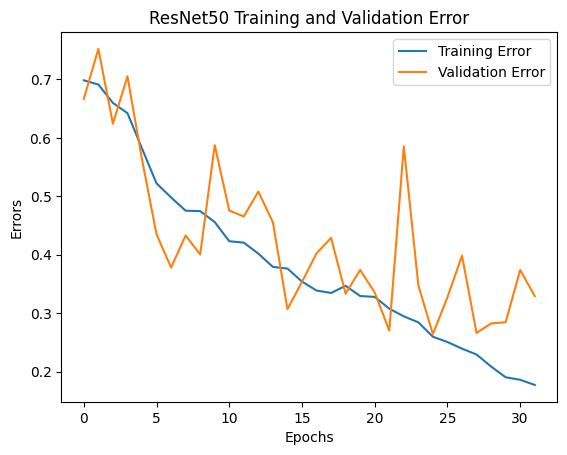

In [ ]:
plot_loss(history, 'ResNet50')

In [ ]:
# Efficient
history_efficinet = train_model(efficientnetb0, 'EfficientNetb0', train_generator, val_generator)

Epoch 1/100
916/916 [==============================] - 41s 35ms/step - loss: 1.0597 - accuracy: 0.6437 - val_loss: 1.8197 - val_accuracy: 0.1931
Epoch 2/100
916/916 [==============================] - 31s 34ms/step - loss: 0.7561 - accuracy: 0.7425 - val_loss: 3.4614 - val_accuracy: 0.2398
Epoch 3/100
916/916 [==============================] - 31s 33ms/step - loss: 0.6192 - accuracy: 0.7822 - val_loss: 4.2882 - val_accuracy: 0.2073
Epoch 4/100
916/916 [==============================] - 31s 33ms/step - loss: 0.5426 - accuracy: 0.8211 - val_loss: 3.4684 - val_accuracy: 0.2378
Epoch 5/100
916/916 [==============================] - 31s 33ms/step - loss: 0.4676 - accuracy: 0.8425 - val_loss: 6.1528 - val_accuracy: 0.1484
Epoch 6/100
916/916 [==============================] - 31s 34ms/step - loss: 0.4458 - accuracy: 0.8552 - val_loss: 7.2540 - val_accuracy: 0.1911
Epoch 7/100
916/916 [==============================] - 31s 34ms/step - loss: 0.3701 - accuracy: 0.8807 - val_loss: 4.4529 - val_ac

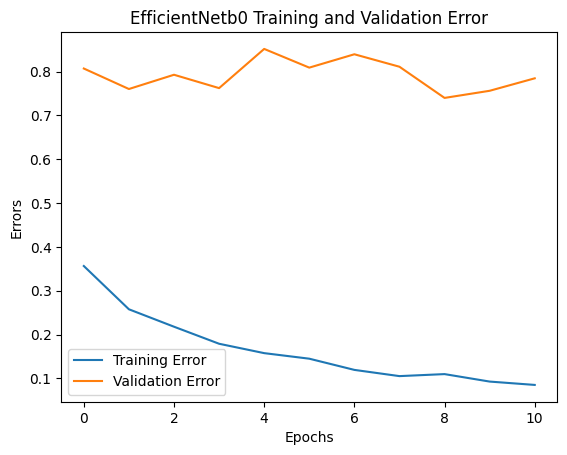

In [ ]:
plot_loss(history_efficinet, 'EfficientNetb0')

In [ ]:
# VGG16
history_vgg16 = train_model(vgg16, 'VGG16', train_generator, val_generator)

Epoch 1/100
916/916 [==============================] - 18s 19ms/step - loss: 1.6299 - accuracy: 0.2879 - val_loss: 3.0721 - val_accuracy: 0.2154
Epoch 2/100
916/916 [==============================] - 17s 18ms/step - loss: 1.5779 - accuracy: 0.3292 - val_loss: 2.1086 - val_accuracy: 0.3740
Epoch 3/100
916/916 [==============================] - 17s 18ms/step - loss: 1.4974 - accuracy: 0.3801 - val_loss: 1.8093 - val_accuracy: 0.3150
Epoch 4/100
916/916 [==============================] - 17s 18ms/step - loss: 1.4314 - accuracy: 0.4266 - val_loss: 1.9041 - val_accuracy: 0.3313
Epoch 5/100
916/916 [==============================] - 17s 18ms/step - loss: 1.3119 - accuracy: 0.4930 - val_loss: 4.0228 - val_accuracy: 0.4776
Epoch 6/100
916/916 [==============================] - 17s 18ms/step - loss: 1.2645 - accuracy: 0.5035 - val_loss: 1.3569 - val_accuracy: 0.4736
Epoch 7/100
916/916 [==============================] - 17s 18ms/step - loss: 1.2188 - accuracy: 0.5236 - val_loss: 1.0896 - val_ac

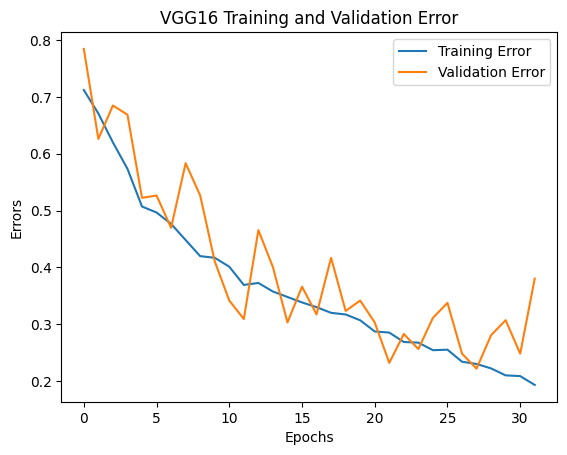

In [ ]:
plot_loss(history_vgg16, 'VGG16')

### Report

In [ ]:
def get_predictions(model, data):
    predictions = model.predict(data)
    pred = np.argmax(predictions, axis=1)
    true = data.classes
    return true, pred

#### Resnet50

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255.0).flow_from_directory(
                                                        train_path, target_size=(244,244), batch_size=5, shuffle=False)

Found 4578 images belonging to 5 classes.


In [ ]:
y_train_true, y_train_pred = get_predictions(resnet, train_generator)
y_test_true, y_test_pred =  get_predictions(resnet, test_generator)

97/97 [==============================] - 2s 16ms/step


In [ ]:
# Training set
print(confusion_matrix(y_train_true, y_train_pred))
print(classification_report(y_train_true, y_train_pred))
print(f'Accuracy:{accuracy_score(y_train_true, y_train_pred)}')

[[831   7  79  89  18]
 [ 21 456  59  66  86]
 [ 13   7 759  67  36]
 [ 42  12  50 862  34]
 [ 24  46 112  71 731]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1024
           1       0.86      0.66      0.75       688
           2       0.72      0.86      0.78       882
           3       0.75      0.86      0.80      1000
           4       0.81      0.74      0.77       984

    accuracy                           0.79      4578
   macro avg       0.81      0.79      0.79      4578
weighted avg       0.80      0.79      0.79      4578

Accuracy:0.7948885976408913


In [ ]:
# Test set
print(confusion_matrix(y_test_true, y_test_pred))
print(classification_report(y_test_true, y_test_pred))
print(f'Accuracy:{accuracy_score(y_test_true, y_test_pred)}')

[[83  2 10  9  4]
 [ 1 55  2  7  8]
 [ 1  3 61 16  8]
 [ 5  2 11 86  2]
 [ 1  4  8 21 71]]
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       108
           1       0.83      0.75      0.79        73
           2       0.66      0.69      0.67        89
           3       0.62      0.81      0.70       106
           4       0.76      0.68      0.72       105

    accuracy                           0.74       481
   macro avg       0.76      0.74      0.74       481
weighted avg       0.76      0.74      0.74       481

Accuracy:0.7401247401247402


#### EfficientNetb0

In [ ]:
y_train_true, y_train_pred = get_predictions(efficientnetb0, train_generator)
y_test_true, y_test_pred =  get_predictions(efficientnetb0, test_generator)

97/97 [==============================] - 2s 15ms/step


In [ ]:
# Training set
print(confusion_matrix(y_train_true, y_train_pred))
print(classification_report(y_train_true, y_train_pred))
print(f'Accuracy:{accuracy_score(y_train_true, y_train_pred)}')

[[   0    3 1021    0    0]
 [   0    9  679    0    0]
 [   0    4  878    0    0]
 [   0    1  999    0    0]
 [   0    1  983    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1024
           1       0.50      0.01      0.03       688
           2       0.19      1.00      0.32       882
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00       984

    accuracy                           0.19      4578
   macro avg       0.14      0.20      0.07      4578
weighted avg       0.11      0.19      0.07      4578

Accuracy:0.19375273044997815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test set
print(confusion_matrix(y_test_true, y_test_pred))
print(classification_report(y_test_true, y_test_pred))
print(f'Accuracy:{accuracy_score(y_test_true, y_test_pred)}')

[[  0   0 108   0   0]
 [  0   3  70   0   0]
 [  0   3  86   0   0]
 [  0   1 105   0   0]
 [  0   1 104   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.38      0.04      0.07        73
           2       0.18      0.97      0.31        89
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00       105

    accuracy                           0.19       481
   macro avg       0.11      0.20      0.08       481
weighted avg       0.09      0.19      0.07       481

Accuracy:0.18503118503118504


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### VGG16

In [ ]:
y_train_true, y_train_pred = get_predictions(vgg16, train_generator)
y_test_true, y_test_pred =  get_predictions(vgg16, test_generator)

97/97 [==============================] - 1s 15ms/step


In [ ]:
# Training set
print(confusion_matrix(y_train_true, y_train_pred))
print(classification_report(y_train_true, y_train_pred))
print(f'Accuracy:{accuracy_score(y_train_true, y_train_pred)}')

[[822  39 102  43  18]
 [  4 528  52  20  84]
 [ 13  13 782  31  43]
 [ 48  25  83 822  22]
 [ 17  60 120  32 755]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1024
           1       0.79      0.77      0.78       688
           2       0.69      0.89      0.77       882
           3       0.87      0.82      0.84      1000
           4       0.82      0.77      0.79       984

    accuracy                           0.81      4578
   macro avg       0.82      0.81      0.81      4578
weighted avg       0.82      0.81      0.81      4578

Accuracy:0.8101791175185671


In [ ]:
# Test set
print(confusion_matrix(y_test_true, y_test_pred))
print(classification_report(y_test_true, y_test_pred))
print(f'Accuracy:{accuracy_score(y_test_true, y_test_pred)}')

[[78  3 11  7  9]
 [ 1 50  4  5 13]
 [ 0  2 69  6 12]
 [ 9  1 14 78  4]
 [ 1  6  8 11 79]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       108
           1       0.81      0.68      0.74        73
           2       0.65      0.78      0.71        89
           3       0.73      0.74      0.73       106
           4       0.68      0.75      0.71       105

    accuracy                           0.74       481
   macro avg       0.75      0.73      0.74       481
weighted avg       0.75      0.74      0.74       481

Accuracy:0.735966735966736


# Video Classification Using Moving Averages

Merge train, val, test data

In [ ]:
data_folder = [train_path, val_path, test_path]
activities = ['baseball', 'volleyball', 'basketball', 'tennis', 'fencing']

os.makedirs('/content/drive/MyDrive/DSCI552/Data/Sport Images/Combined')
for activity in activities:
    os.makedirs(os.path.join('/content/drive/MyDrive/DSCI552/Data/Sport Images/Combined', activity))

for activity in activities:
    for folder in data_folder:
        source = os.path.join(folder, activity)
        destination = os.path.join('/content/drive/MyDrive/DSCI552/Data/Sport Images/Combined', activity)
        
        for file in os.listdir(source):
            source_file = os.path.join(source, file)
            destination_file = os.path.join(destination, file)
            shutil.copy(source_file, destination_file)

Reuse the validation and test data and train the network

In [ ]:
combined_train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('/content/drive/MyDrive/DSCI552/Data/Sport Images/Combined',
                                                                                 target_size=(224,224),
                                                                                 batch_size=5,
                                                                                 class_mode='categorical')

Found 5551 images belonging to 5 classes.


In [ ]:
new_resnet_history = resnet.fit(combined_train_generator, epochs=32, batch_size=5)

Epoch 1/32
1111/1111 [==============================] - 31s 27ms/step - loss: 0.9390 - accuracy: 0.6590
Epoch 2/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.9060 - accuracy: 0.6792
Epoch 3/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.8672 - accuracy: 0.6792
Epoch 4/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.8339 - accuracy: 0.6965
Epoch 5/32
1111/1111 [==============================] - 28s 26ms/step - loss: 0.7799 - accuracy: 0.7208
Epoch 6/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.7876 - accuracy: 0.7116
Epoch 7/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.7716 - accuracy: 0.7246
Epoch 8/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.7136 - accuracy: 0.7509
Epoch 9/32
1111/1111 [==============================] - 29s 26ms/step - loss: 0.8004 - accuracy: 0.7096
Epoch 10/32
1111/1111 [==============================] - 29s 26m

In [ ]:
new_efficientnetb0_history = efficientnetb0.fit(combined_train_generator, epochs=11, batch_size=5)

Epoch 1/11
1111/1111 [==============================] - 34s 31ms/step - loss: 1.1352 - accuracy: 0.5880
Epoch 2/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.8024 - accuracy: 0.7168
Epoch 3/11
1111/1111 [==============================] - 34s 30ms/step - loss: 0.6555 - accuracy: 0.7662
Epoch 4/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.5355 - accuracy: 0.8155
Epoch 5/11
1111/1111 [==============================] - 34s 30ms/step - loss: 0.4723 - accuracy: 0.8462
Epoch 6/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.4217 - accuracy: 0.8604
Epoch 7/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.3663 - accuracy: 0.8788
Epoch 8/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.3124 - accuracy: 0.9002
Epoch 9/11
1111/1111 [==============================] - 34s 31ms/step - loss: 0.3303 - accuracy: 0.8959
Epoch 10/11
1111/1111 [==============================] - 34s 30m

In [ ]:
new_vgg16_history = vgg16.fit(combined_train_generator, epochs=32, batch_size=5)

Epoch 1/32
1111/1111 [==============================] - 18s 15ms/step - loss: 0.8508 - accuracy: 0.7047
Epoch 2/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.8078 - accuracy: 0.7139
Epoch 3/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.7807 - accuracy: 0.7319
Epoch 4/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.7729 - accuracy: 0.7264
Epoch 5/32
1111/1111 [==============================] - 18s 16ms/step - loss: 0.7488 - accuracy: 0.7413
Epoch 6/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.7051 - accuracy: 0.7633
Epoch 7/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.7000 - accuracy: 0.7600
Epoch 8/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.6837 - accuracy: 0.7770
Epoch 9/32
1111/1111 [==============================] - 17s 15ms/step - loss: 0.6650 - accuracy: 0.7730
Epoch 10/32
1111/1111 [==============================] - 17s 15m

Apply at lease L equally spaced frames of each video

In [ ]:
def preprocess_video(activity_path, model, preprocess_input):
    y_true = []
    y_pred = []
    
    for activity_label, activity_folder in enumerate(os.listdir(activity_path)):
        activity_folder_path = os.path.join(activity_path, activity_folder)
        
        for video in os.listdir(activity_folder_path):
            video_path = os.path.join(activity_folder_path, video)
            cap = cv2.VideoCapture(video_path)
            total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_step = max(1, total_frame // 101)
            
            prob = []
            for i, j in enumerate(range(0, total_frame, frame_step)):
                if len(prob) >= 100:
                  break
                cap.set(cv2.CAP_PROP_POS_FRAMES, j)
                ret, frame = cap.read()
                if not ret:
                    continue
                img = cv2.resize(frame, (224,224))
                img = img_to_array(img)
                img = preprocess_input(img)
                img = np.expand_dims(img, axis=0)
                
                prediction = model.predict(img)
                prob.append(prediction)
                
            cap.release()
            
            average_p = np.mean(prob, axis=0)
            predicted_class = np.argmax(average_p)
            
            y_true.append(activity_label)
            y_pred.append(predicted_class)

    
    return y_true, y_pred

In [ ]:
models = [('ResNet50', resnet, preprocess_resnet),
        ('Efficientnetb0', efficientnetb0, preprocess_efficientnet),
         ('VGG16', vgg16, preprocess_vgg16)]
activity_path = '/content/drive/MyDrive/DSCI552/Data/Sport Videos'

### EfficientNetB0

In [ ]:
y_true, y_pred = preprocess_video(activity_path, efficientnetb0, preprocess_efficientnet)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names = os.listdir(activity_path))

print(f'For model Efficientnetb0:')
print('Confusion Matrix')
print(cm)
print('\nReport:')
print(report)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
For model Efficientnetb0:
Confusion Matrix
[[  0 181   0   3   0]
 [  0 133   0   4   0]
 [  0 169   0   0   0]
 [  0 113   2   1   0]
 [  0 121   0   0   0]]

Report:
                   precision    recall  f1-score   support

      TennisSwing       0.00      0.00      0.00       184
       Basketball       0.19      0.97      0.31       137
    BaseballPitch       0.00      0.00      0.00       169
VolleyballSpiking       0.12      0.01      0.02       116
          Fencing       0.00      0.00      0.00       121

         accuracy                           0.18       727
        macro avg       0.06      0.20      0.07       727
     weighted avg       0.05      0.18      0.06       727



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ResNet50

In [ ]:
y_true, y_pred = preprocess_video(activity_path, resnet, preprocess_resnet)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names = os.listdir(activity_path))

print(f'For model ResNet50:')
print('Confusion Matrix')
print(cm)
print('\nReport:')
print(report)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
For model ResNet50:
Confusion Matrix
[[  0   0   0   0 184]
 [  0   0   0   0 137]
 [  0   0   0   0 169]
 [  0   0   0   0 116]
 [  0   0   0   0 121]]

Report:
                   precision    recall  f1-score   support

      TennisSwing       0.00      0.00      0.00       184
       Basketball       0.00      0.00      0.00       137
    BaseballPitch       0.00      0.00      0.00       169
VolleyballSpiking       0.00      0.00      0.00       116
          Fencing       0.17      1.00      0.29       121

         accuracy                           0.17       727
        macro avg       0.03      0.20      0.06       727
     weighted avg       0.03      0.17      0.05       727



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16

In [81]:
y_true, y_pred = preprocess_video(activity_path, vgg16, preprocess_vgg16)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names = os.listdir(activity_path))

print(f'For model VGG16:')
print('Confusion Matrix')
print(cm)
print('\nReport:')
print(report)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
For model VGG16:
Confusion Matrix
[[ 39   9   0  34 102]
 [  9   1   0  17 110]
 [ 17   2   0  15 135]
 [ 17   0   0   8  91]
 [ 22   1   0  12  86]]

Report:
                   precision    recall  f1-score   support

      TennisSwing       0.38      0.21      0.27       184
       Basketball       0.08      0.01      0.01       137
    BaseballPitch       0.00      0.00      0.00       169
VolleyballSpiking       0.09      0.07      0.08       116
          Fencing       0.16      0.71      0.27       121

         accuracy                           0.18       727
        macro avg       0.14      0.20      0.13       727
     weighted avg       0.15      0.18      0.13       727



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
